# Visualizations

### Purpose

Create single-subject QA plots and the group level pupil dilation plot showing the main effect of the emotion manipulation and the analysis time window.

### Input <> Output

##### Input
- `~data/interim/adults/*cleaned.parquet`
- `~data/final/adults_final_data.xlsx`

##### Output
- `working_directory/interim_reports` for the single-subject QA visualizations
- `~reports/figures/adults` for the group-level visualization

## Imports

In [1]:
# fmt: off
from pathlib import Path
import sys
sys.path.append(str(Path().cwd().parent/'src'))
import modules.utils as utils
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
import importlib
import seaborn as sns
importlib.reload(utils)
# fmt: on

<module 'modules.utils' from '/Users/lukasspiess/Library/CloudStorage/OneDrive-SpiessSolution/Pupil Dilation Processing/General/Data_analysis/pupil_dilation/src/modules/utils.py'>

## Parameters

In [27]:
WORKING_DIR = Path.cwd()
DATA_DIR = WORKING_DIR.parent / "data"
INTERIM_DATA_DIR = DATA_DIR / "interim" / "adults"
REPORTS_DIR = WORKING_DIR.parent / "reports" / "figures" / "adults"
REPORTS_DIR.mkdir(exist_ok=True, parents=True)
INTERIM_REPORTS_DIR = WORKING_DIR / "interim_reports"
INTERIM_REPORTS_DIR.mkdir(exist_ok=True)

dependent_var_name = "avg_pd_bc_post1500ms"

## Support functions

In [28]:
def pivotted_df_cleaner(df: pd.DataFrame, min_samples_fixation: Union[int, float] = 85, min_samples_stimulus: Union[int, float] = 85) -> pd.DataFrame:
    df = df.reset_index()
    df = df[df["Emotion"] != "neutral"]
    df = df[(df["%samples_fixation"] > min_samples_fixation) &
            (df["%samples_stimulus"] > min_samples_stimulus)]
    df = df.drop(columns=["%samples_fixation", "%samples_stimulus"])
    return df


def pivot_stimulus_data(df: pd.DataFrame, segment_type: str) -> pd.DataFrame:
    """
    Pivot the stimulus data to have the trial_nr as the index and the RelativeTime_ms as the columns
    """
    stimulus_data = df[df.segment_type == segment_type]
    return stimulus_data.pivot(
        index=["ParticipantName", "trial_nr", "segment_type", "%samples_stimulus",
               "%samples_fixation", "Emotion"],
        columns="RelativeTime_ms",
        values="PupilMean_corrected",
    )


def linear_regression_slope_intercept(x, y):
    # Calculate the means of the arrays
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the slope (b1)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean)**2)
    slope = numerator / denominator

    # Calculate the intercept (b0)
    intercept = y_mean - slope * x_mean

    return slope, intercept

# Load data

Load the aggregated data also used for inference

In [29]:
agg_df = pd.read_excel(DATA_DIR / "final" / "adults_final_data.xlsx")
print(agg_df.shape)

subset_agg_df = agg_df[(agg_df["%samples_fixation"] > 85)
                       & (agg_df["%samples_stimulus"] > 85)]
subset_agg_df['Dismissing'] = subset_agg_df['Dismissing'].str.replace(
    ',', '.').astype(float)  # to be able to use as numbers
subset_agg_df['Preoccupied'] = subset_agg_df['Preoccupied'].str.replace(
    ',', '.').astype(float)
print(subset_agg_df.shape)

(12836, 25)
(7516, 25)


Load the low-level pupil dilation timeseries data

In [30]:
# Fixation data
filepath_generator = INTERIM_DATA_DIR.glob("*cleaned.parquet")
dataset_loader = map(pd.read_parquet, filepath_generator)
pivotter = map(lambda x: pivot_stimulus_data(x, "fixation"), dataset_loader)
df_cleaner = map(pivotted_df_cleaner, pivotter)
fixation_df = pd.concat(df_cleaner)

# Stimulus data
filepath_generator = INTERIM_DATA_DIR.glob("*cleaned.parquet")
dataset_loader = map(pd.read_parquet, filepath_generator)
pivotter = map(lambda x: pivot_stimulus_data(x, "stimulus"), dataset_loader)
df_cleaner = map(pivotted_df_cleaner, pivotter)
stimulus_df = pd.concat(df_cleaner)

In [31]:
# Aggregate the data into 16ms bins
stimulus_df = stimulus_df.set_index(
    ["ParticipantName",	"trial_nr", "Emotion", "segment_type"])
fixation_df = fixation_df.set_index(
    ["ParticipantName",	"trial_nr", "Emotion", "segment_type"])

# Round each column name to the nearest 16ms and create a mapping
rounded_columns_stimulus_df = {col: utils.round_to_nearest_16ms(
    int(col)) for col in stimulus_df.columns}
rounded_columns_fixation_df = {col: utils.round_to_nearest_16ms(
    int(col)) for col in fixation_df.columns}

# Use the mapping to rename the columns, aggregating by taking the mean where columns collapse
plt_stimulus_df = (
    stimulus_df.rename(columns=rounded_columns_stimulus_df).groupby(
        level=0, axis=1).mean()
)
plt_fixation_df = (
    fixation_df.rename(columns=rounded_columns_fixation_df).groupby(
        level=0, axis=1).mean()
)

# Visualization #1
Visualize the Pupil dilation timeseries

In [32]:
# select the data
sad_stim_df = plt_stimulus_df[plt_stimulus_df.index.get_level_values(
    "Emotion") == "sad"]
happy_stim_df = plt_stimulus_df[plt_stimulus_df.index.get_level_values(
    "Emotion") == "happy"]

sad_fix_df = plt_fixation_df[plt_fixation_df.index.get_level_values(
    "Emotion") == "sad"]
happy_fix_df = plt_fixation_df[plt_fixation_df.index.get_level_values(
    "Emotion") == "happy"]

# calculate average pupil dilation per time bin of 16ms
sad_stim_means = sad_stim_df.mean(axis=0)
happy_stim_means = happy_stim_df.mean(axis=0)
sad_fix_means = sad_fix_df.mean(axis=0)
happy_fix_means = happy_fix_df.mean(axis=0)

In [33]:
# Prepare data for plotting
t = np.concatenate([sad_fix_means.index.values,
                   (sad_stim_means.index + sad_fix_means.index[-1]).values])
sad_means = pd.concat([sad_fix_means, sad_stim_means])
sad_means.index = t

happy_means = pd.concat([happy_fix_means, happy_stim_means])
happy_means.index = t

/Users/lukasspiess/Library/CloudStorage/OneDrive-SpiessSolution/Pupil Dilation Processing/General/Data_analysis/pupil_dilation/reports/figures/adults/pd_ts_condition.png


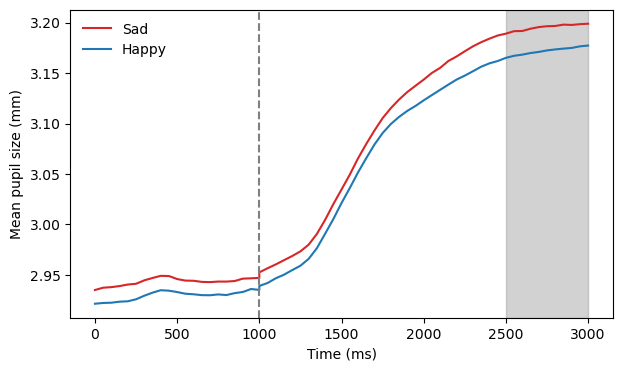

In [34]:
# The Visualization
plt.figure(figsize=(7, 4))
plt.plot(sad_means, label="Sad", color="C3")
plt.plot(happy_means, label="Happy")
plt.legend(frameon=False)
plt.ylabel("Mean pupil size (mm)")
plt.xlabel("Time (ms)")
plt.axvline(x=1000, color='gray', linestyle='--')
plt.axvspan(2500, 3000, color='gray', alpha=0.35)
# plt.show()

plt.savefig(REPORTS_DIR / "pd_ts_condition.png", dpi=300)
print(str(REPORTS_DIR / "pd_ts_condition.png"))

# Visualize SingleSubject conditions

In [36]:
INTERIM_REPORTS_DIR

PosixPath('/Users/lukasspiess/Library/CloudStorage/OneDrive-SpiessSolution/Pupil Dilation Processing/General/Data_analysis/pupil_dilation/development notebooks/interim_reports')

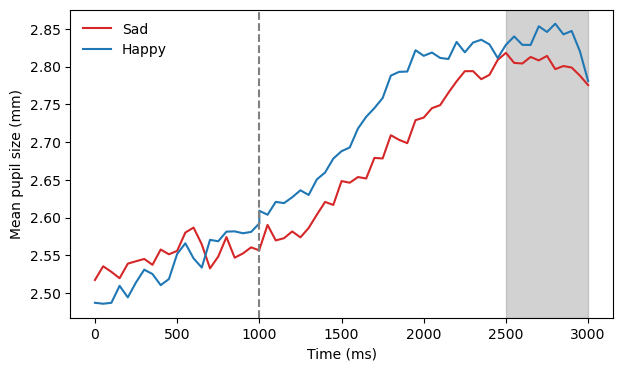

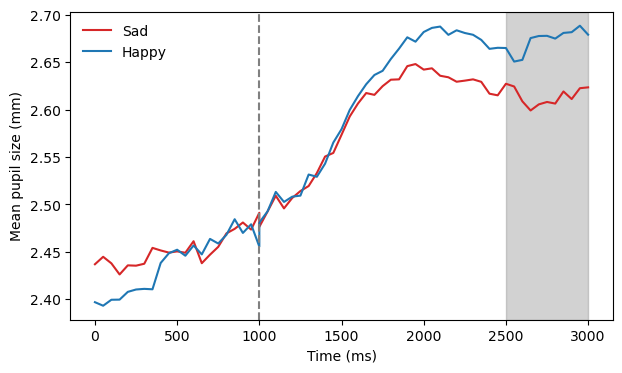

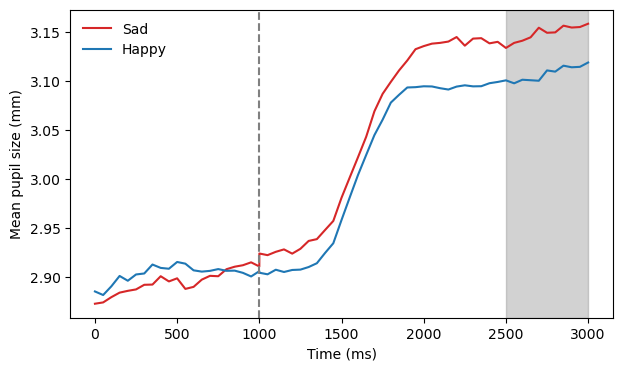

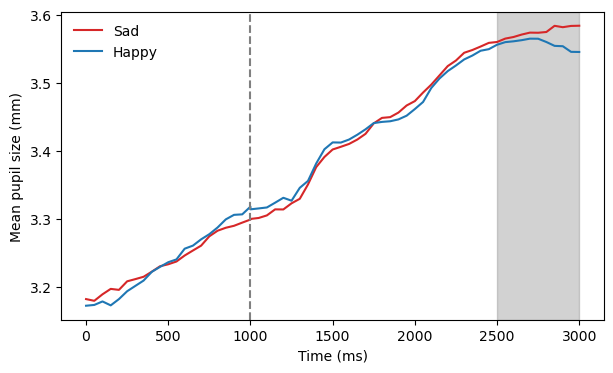

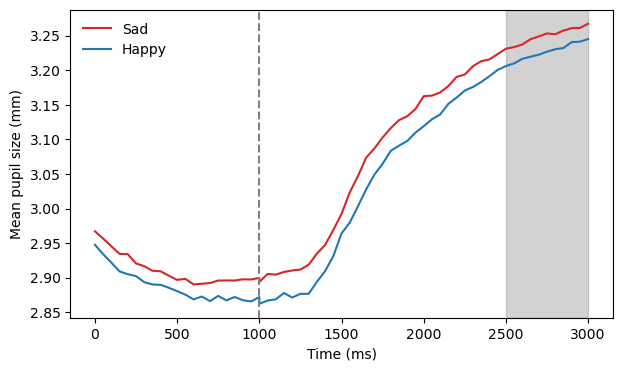

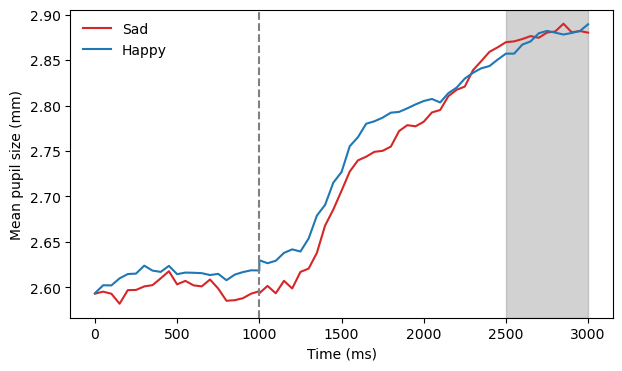

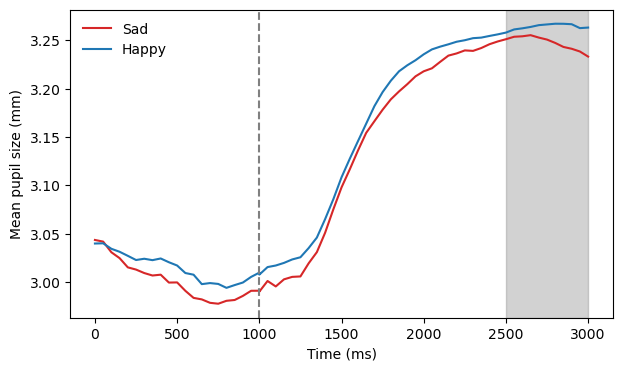

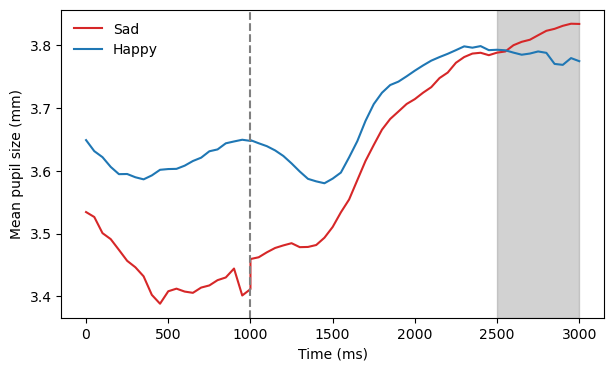

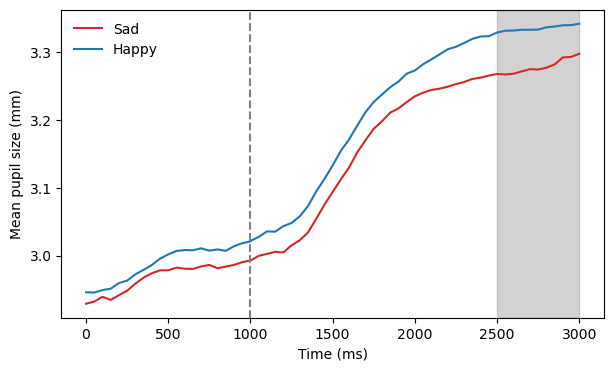

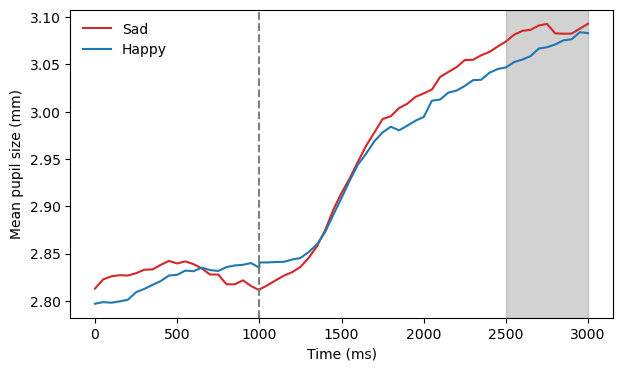

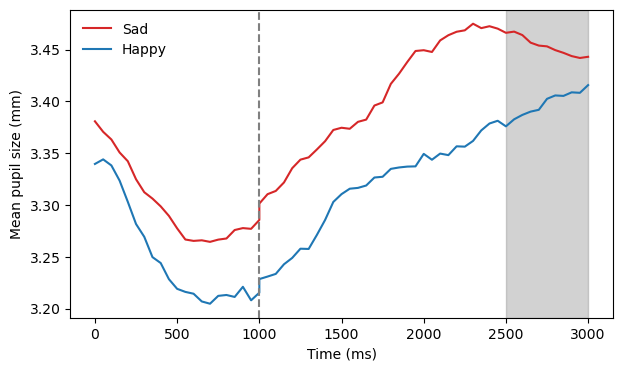

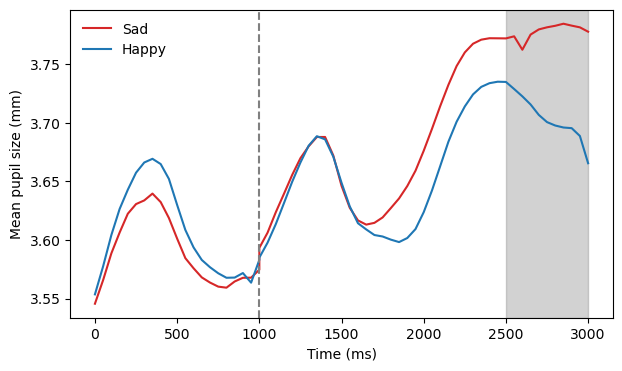

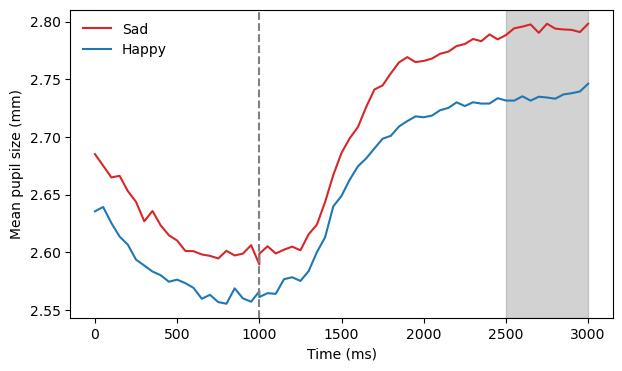

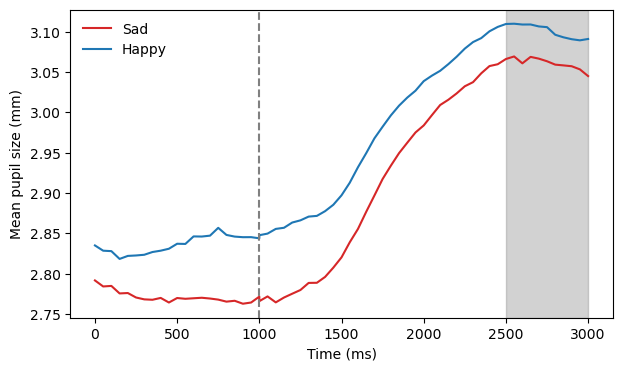

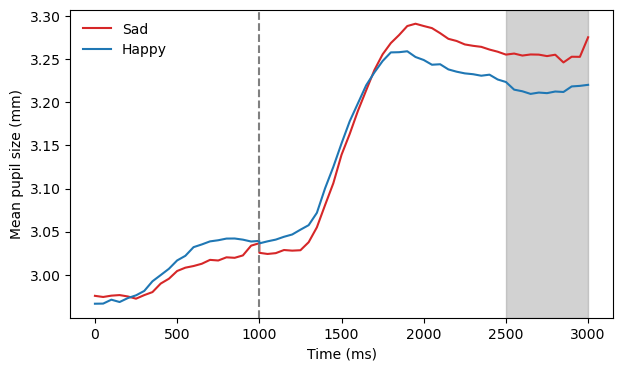

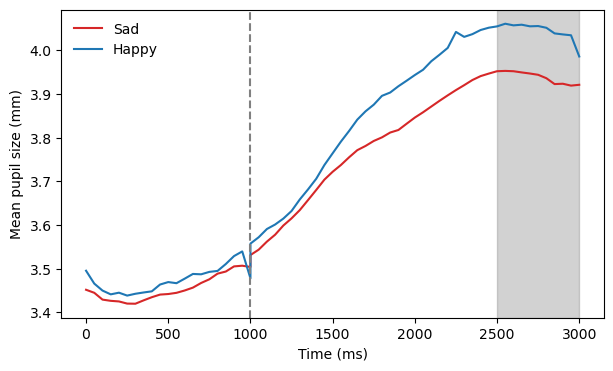

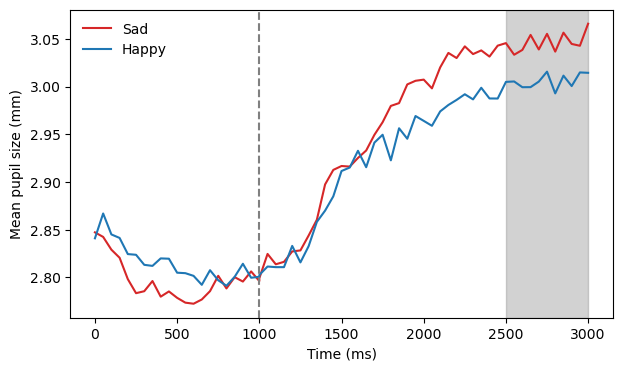

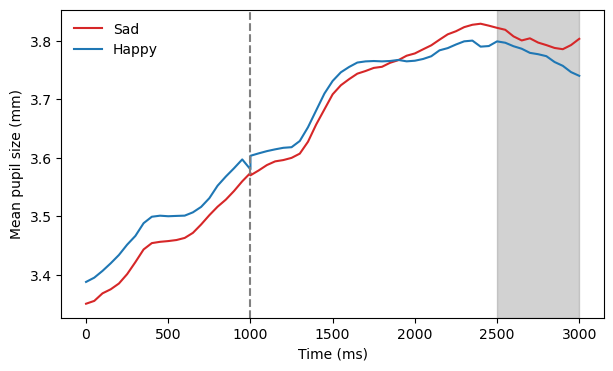

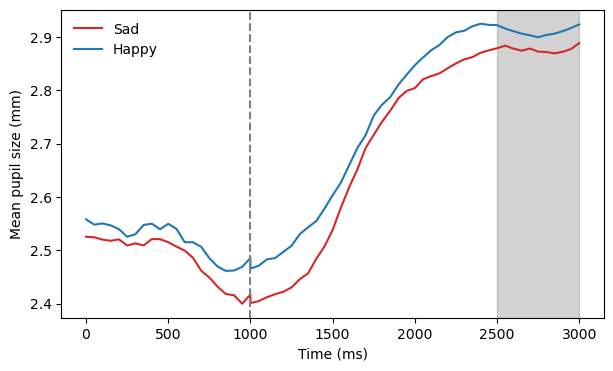

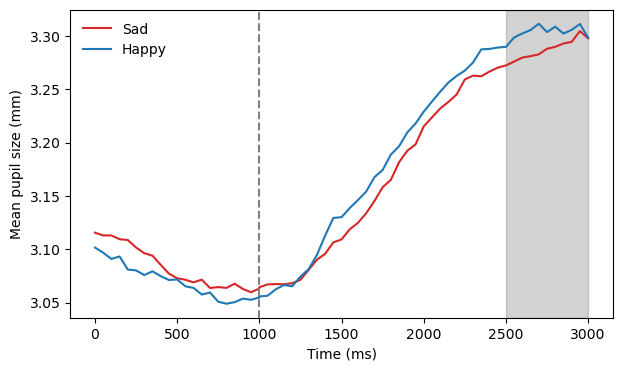

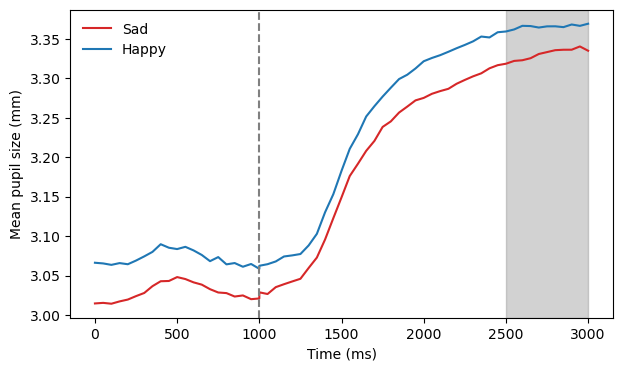

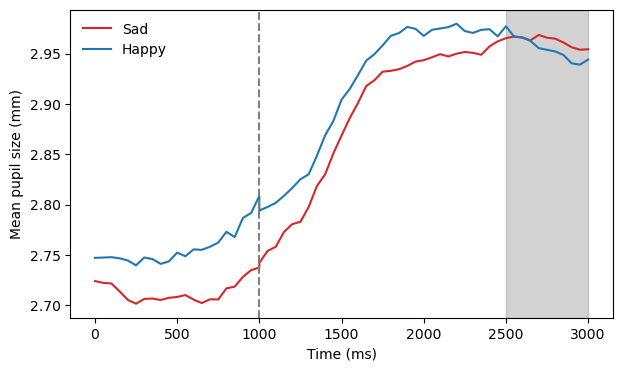

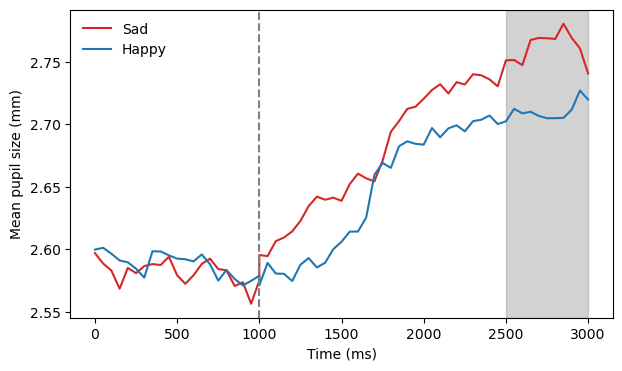

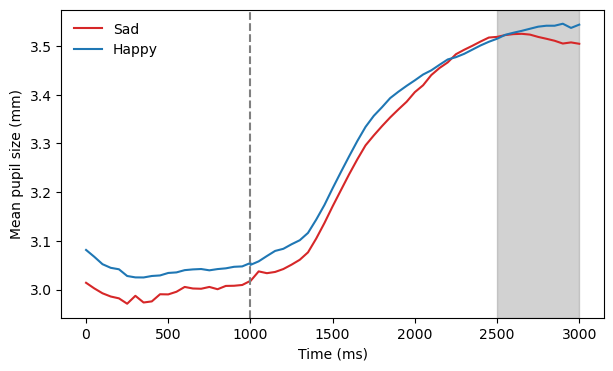

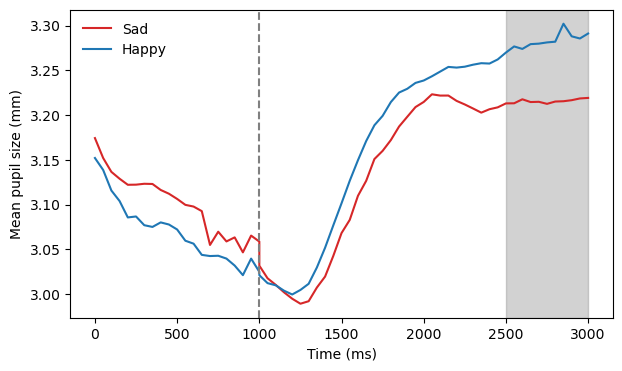

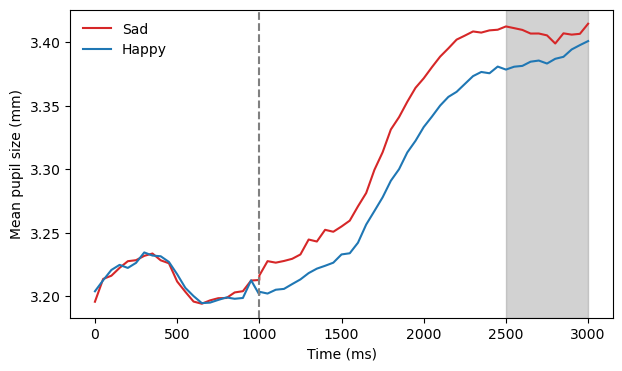

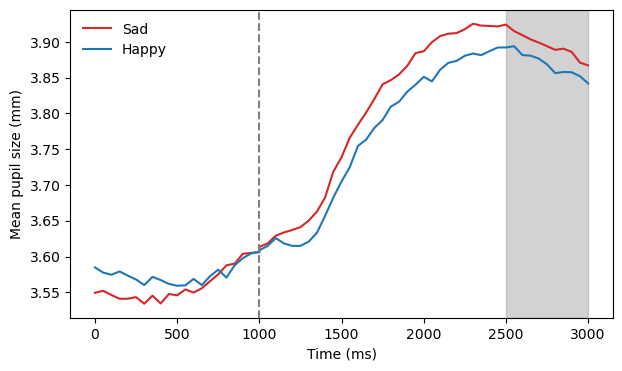

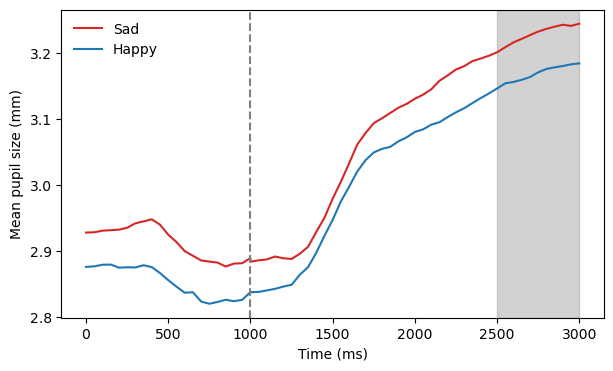

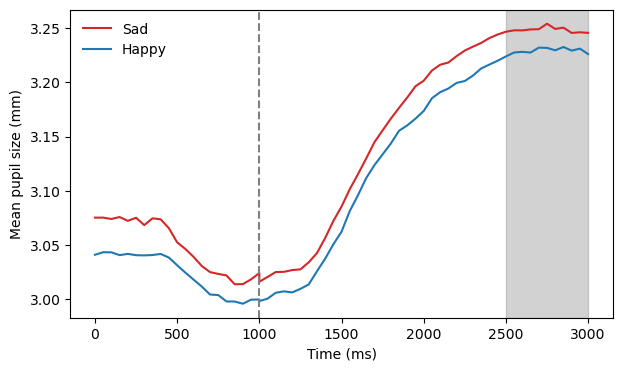

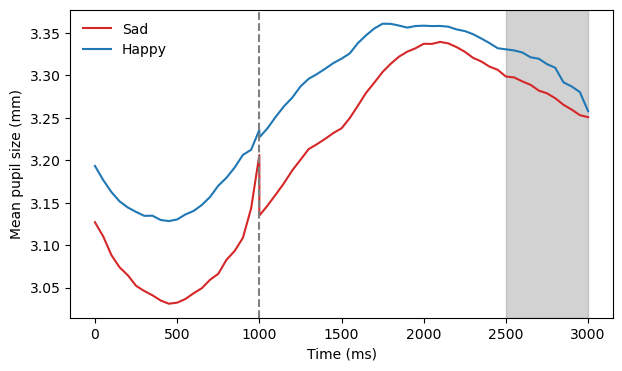

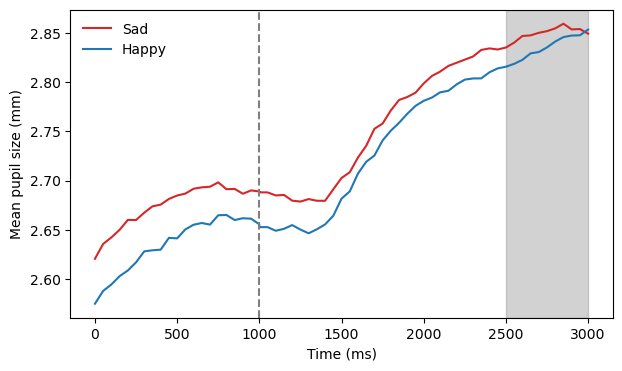

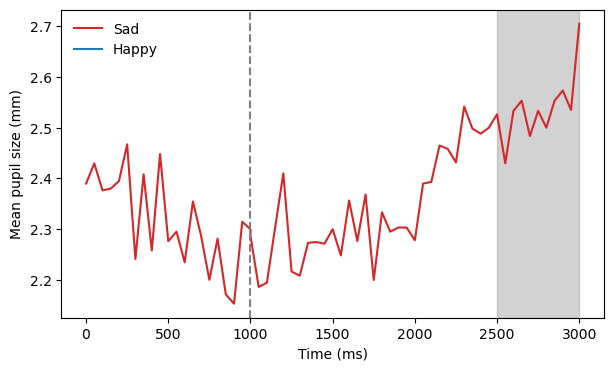

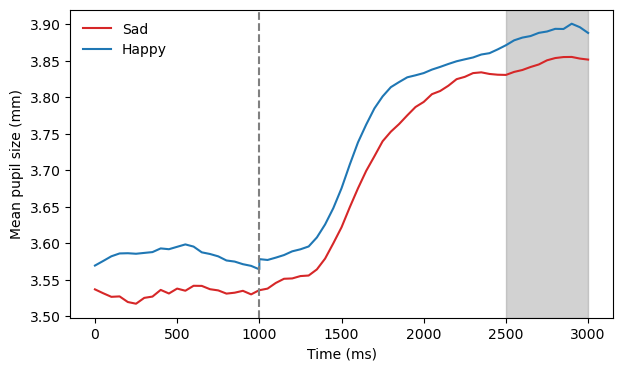

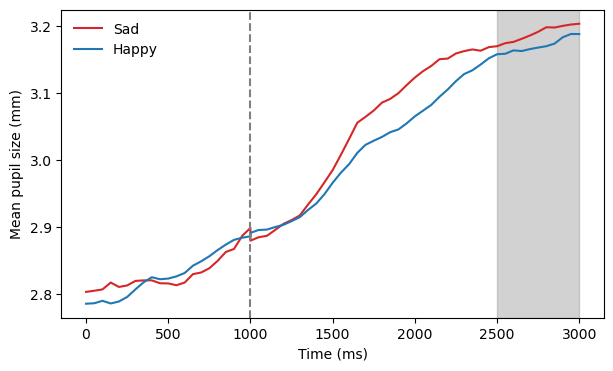

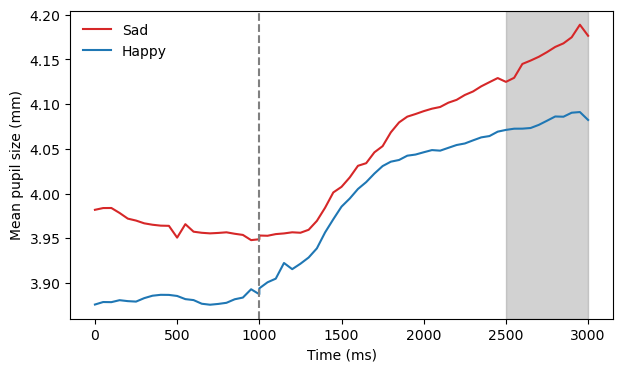

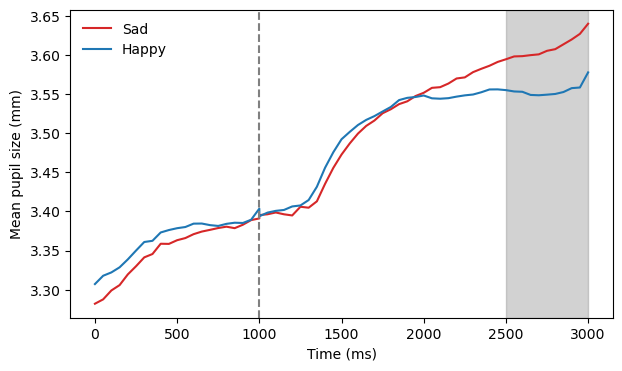

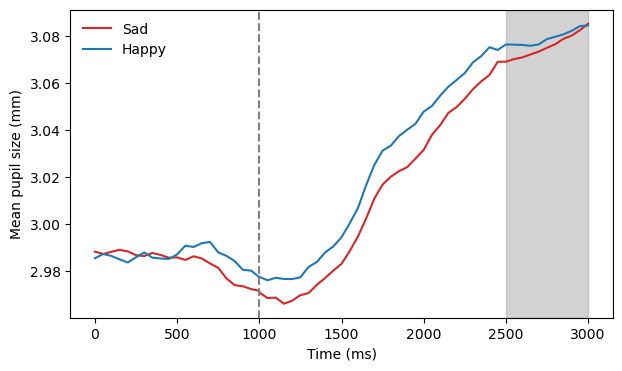

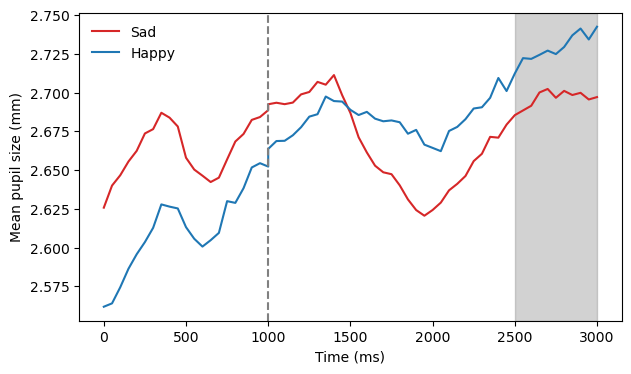

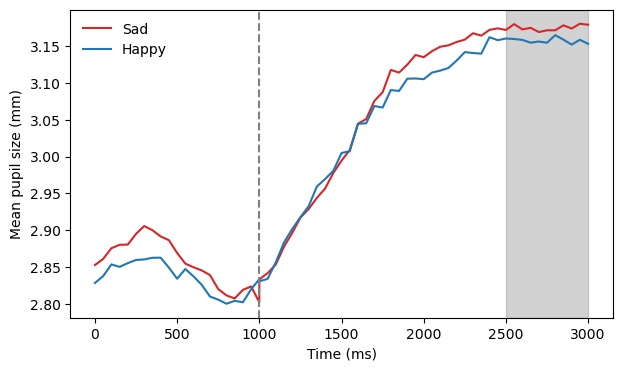

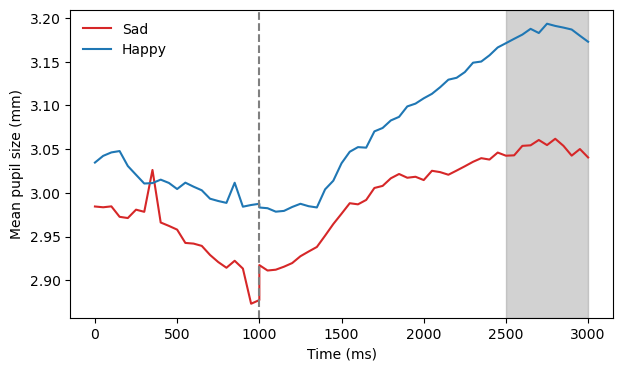

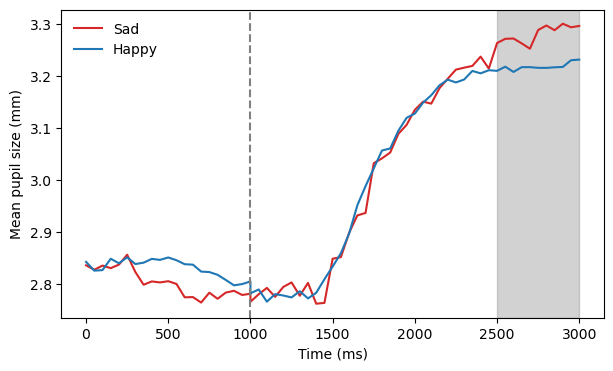

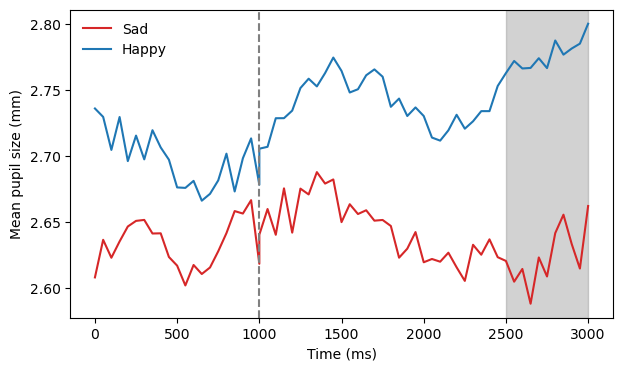

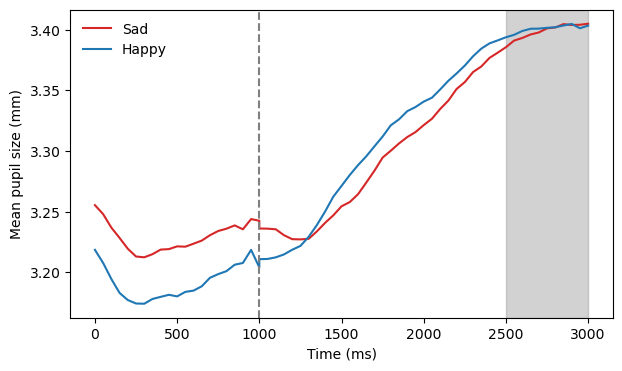

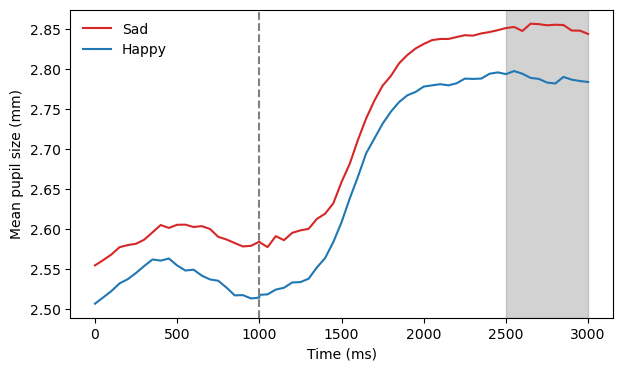

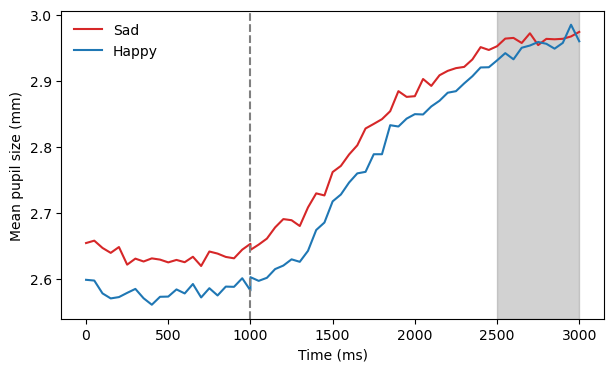

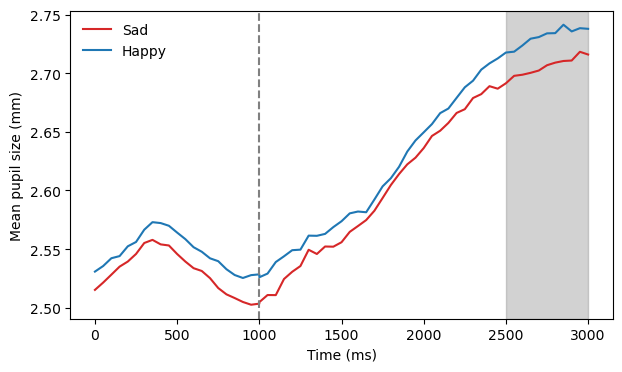

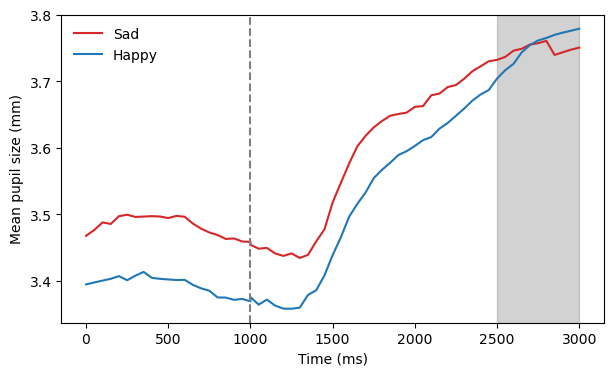

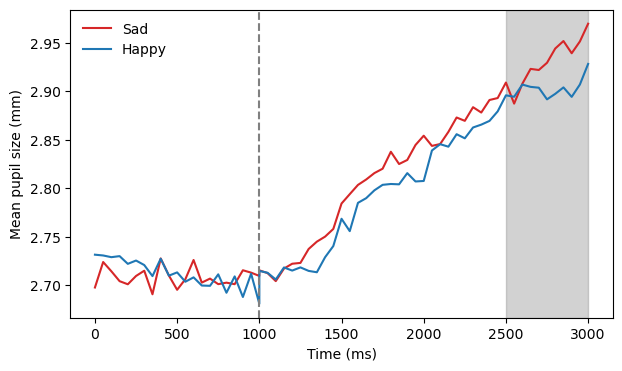

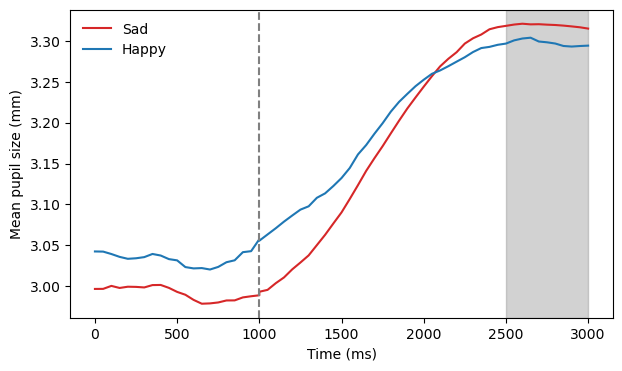

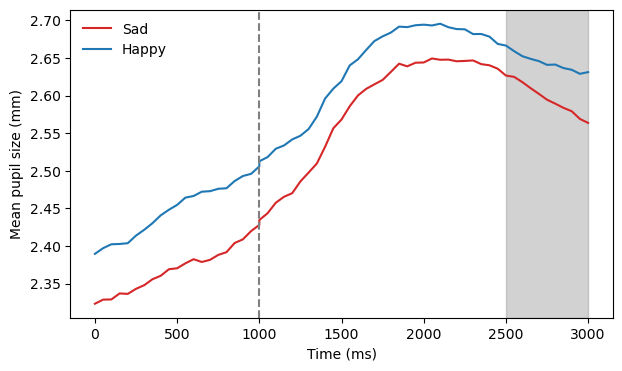

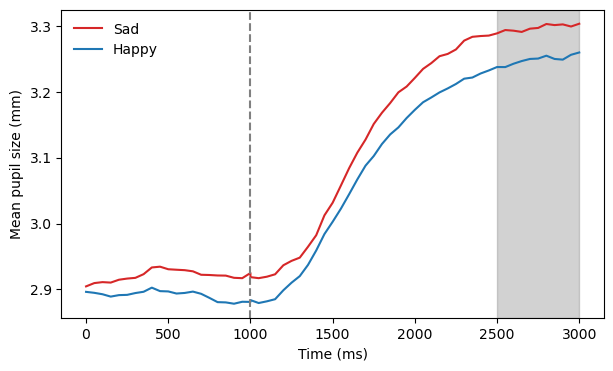

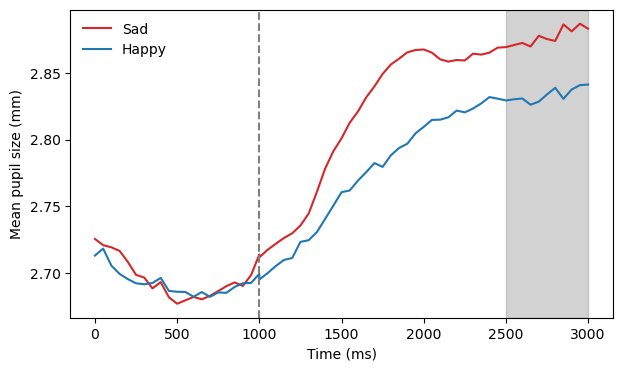

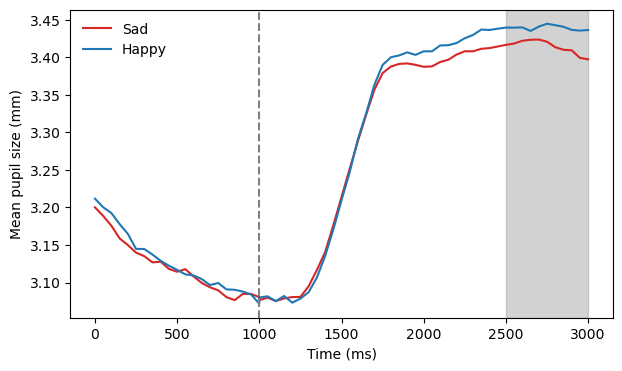

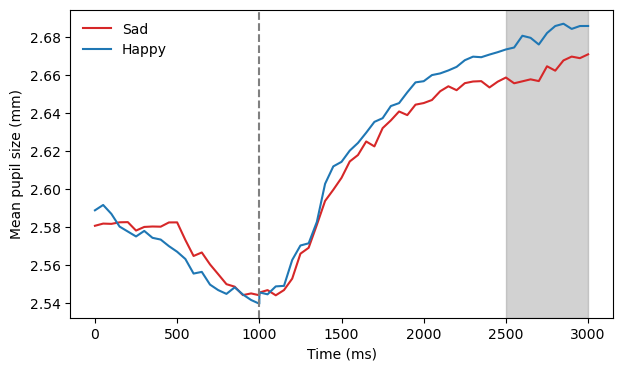

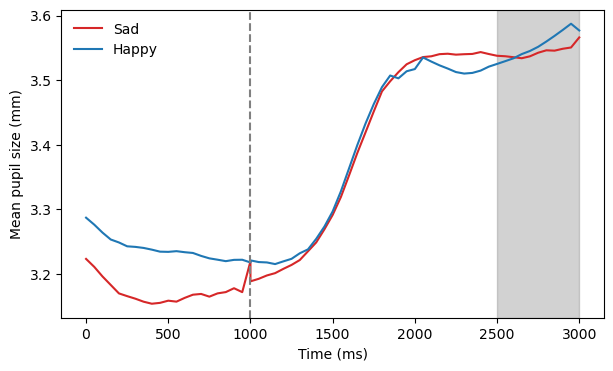

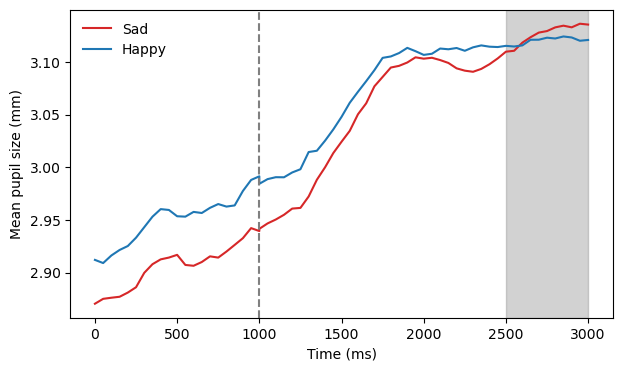

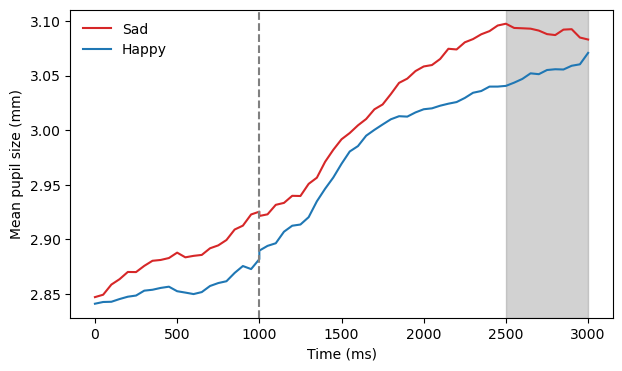

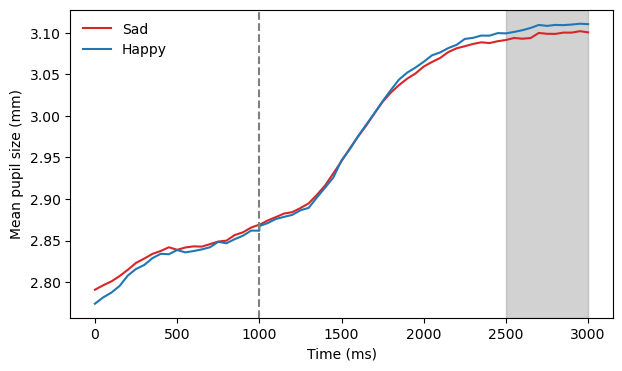

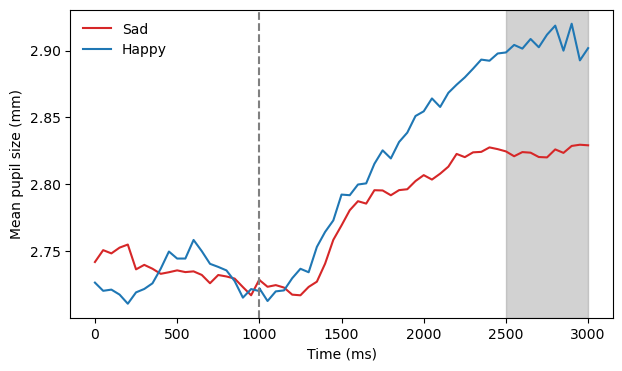

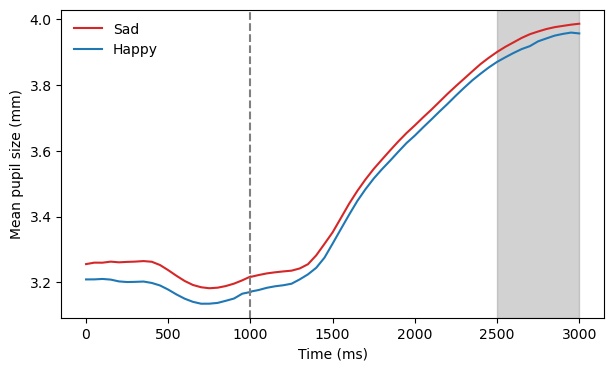

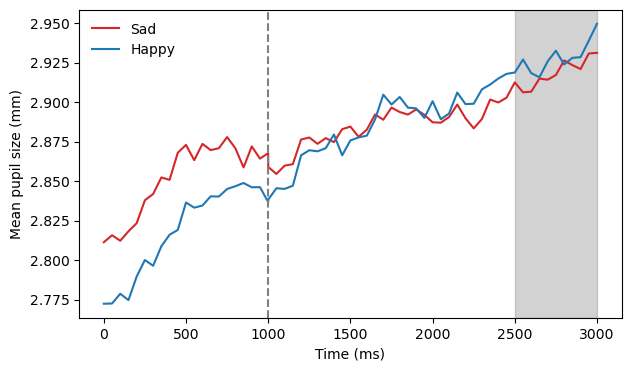

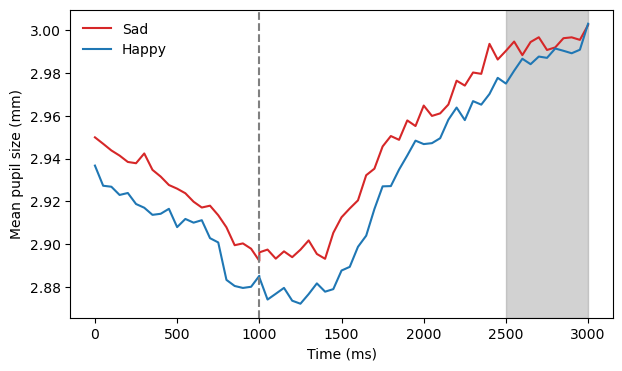

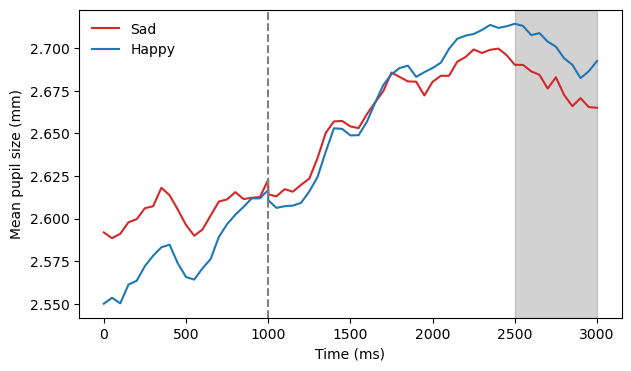

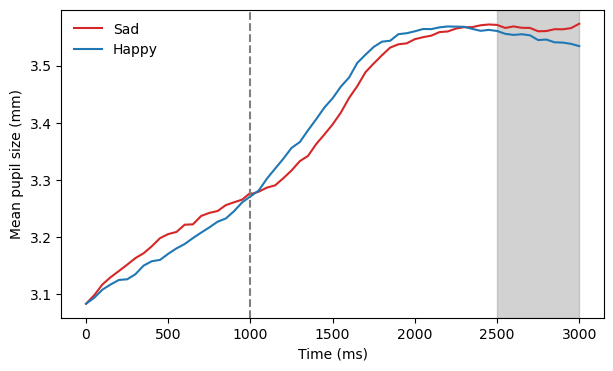

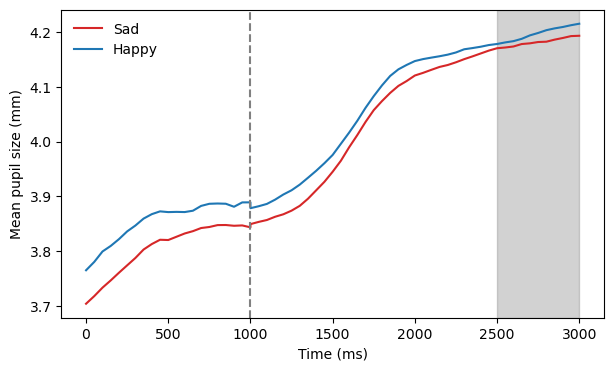

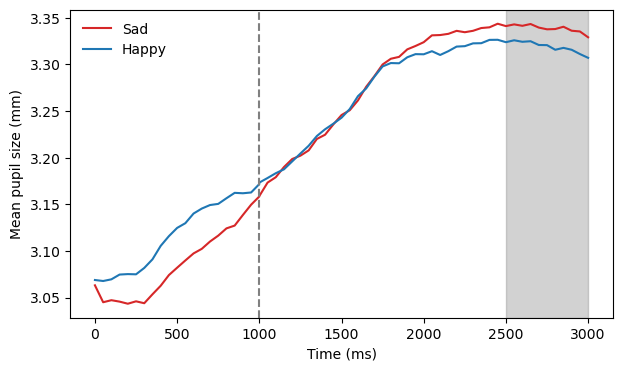

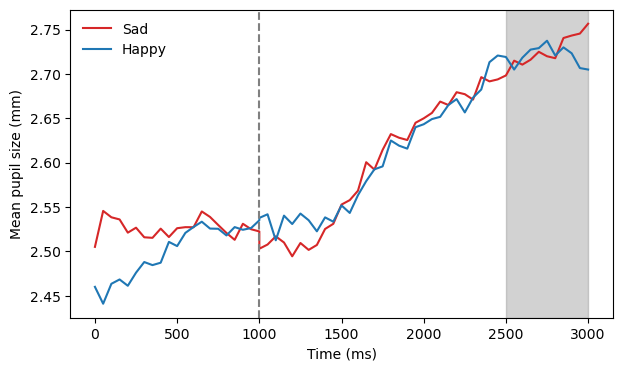

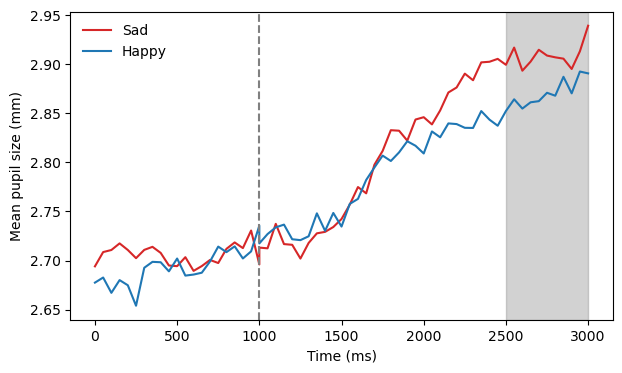

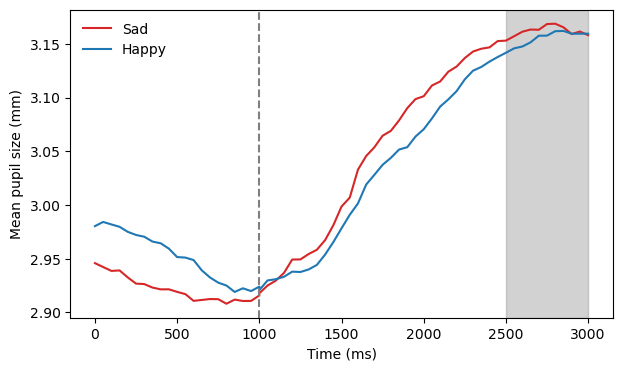

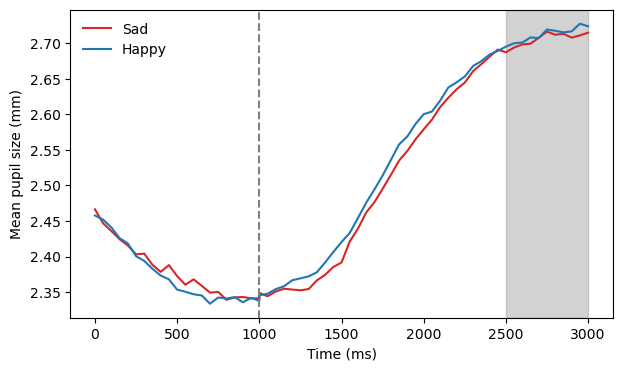

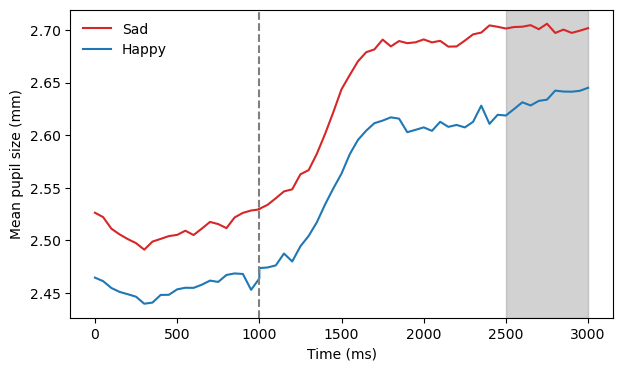

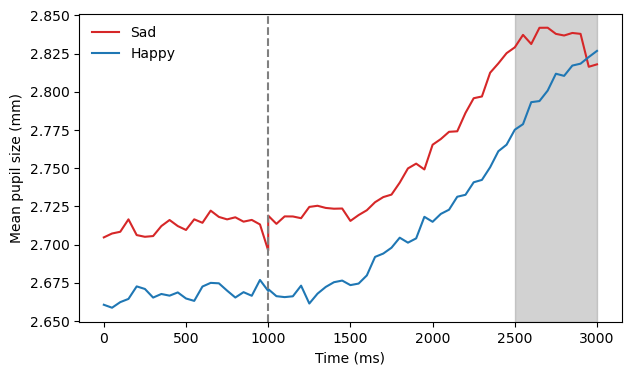

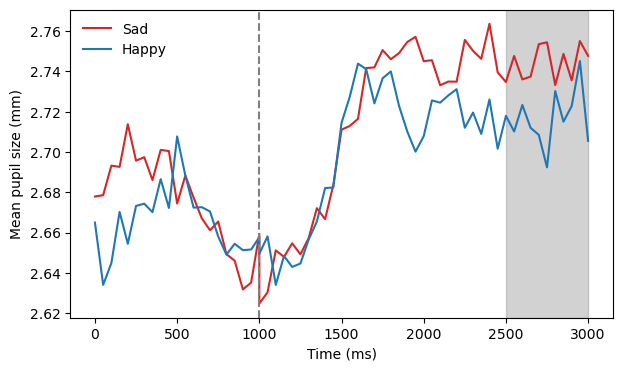

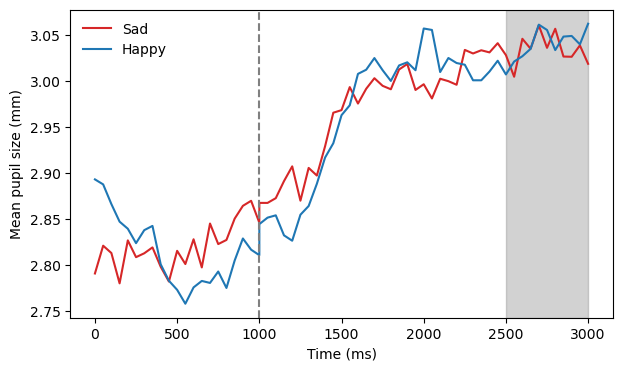

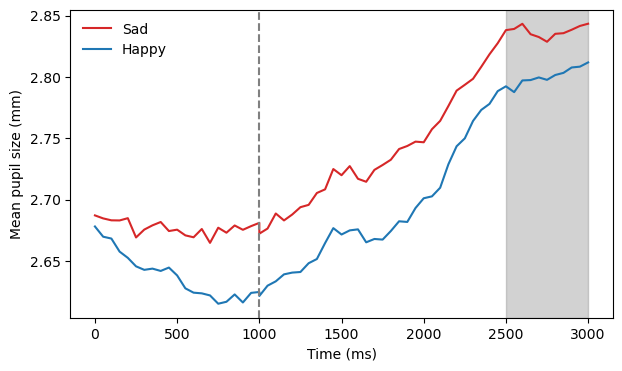

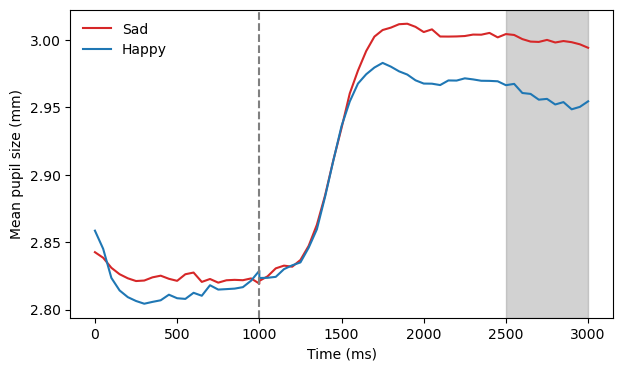

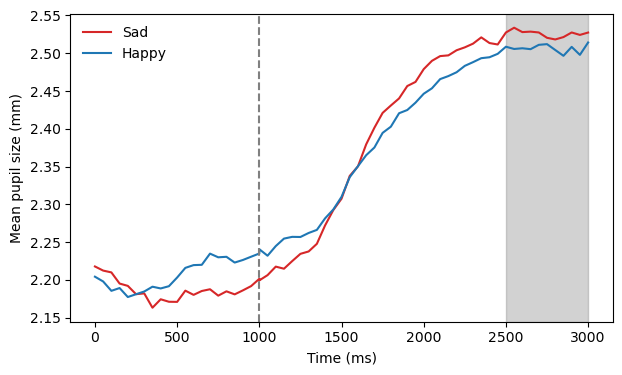

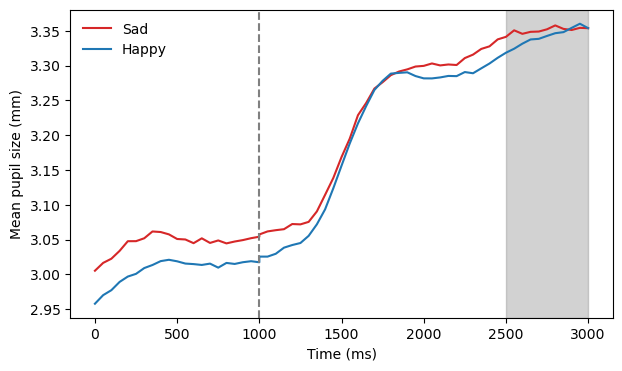

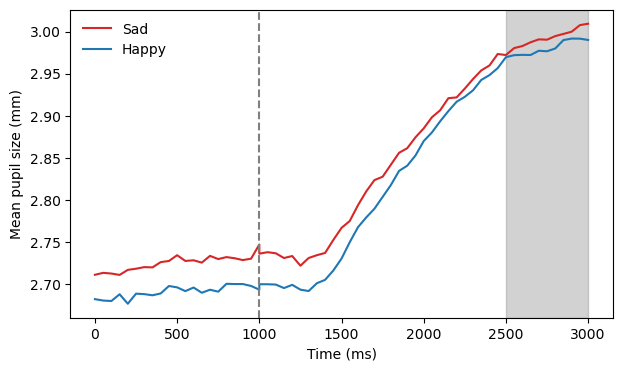

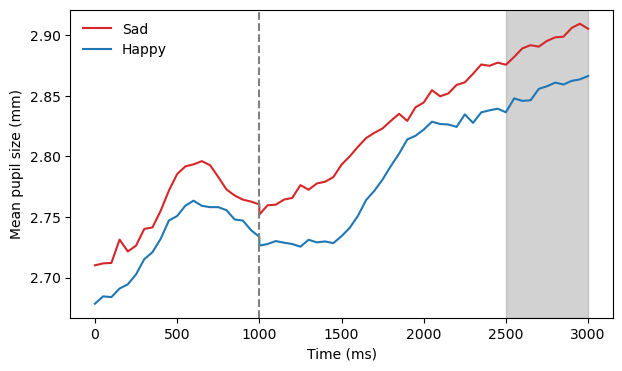

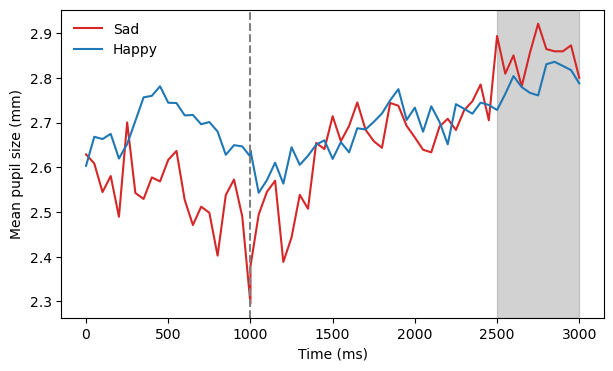

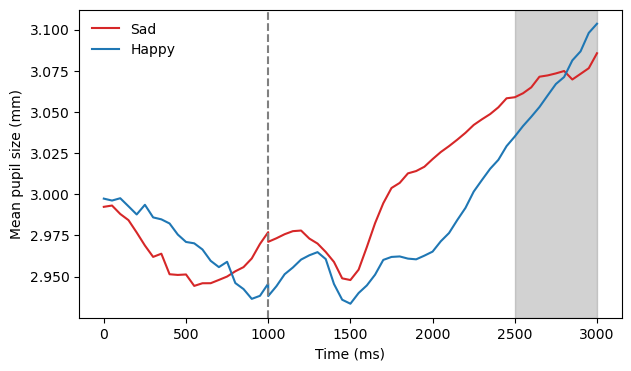

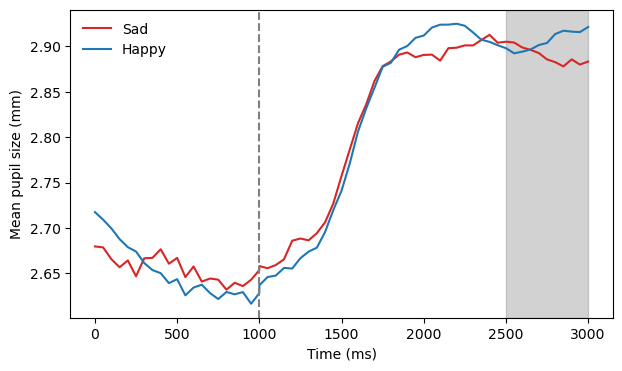

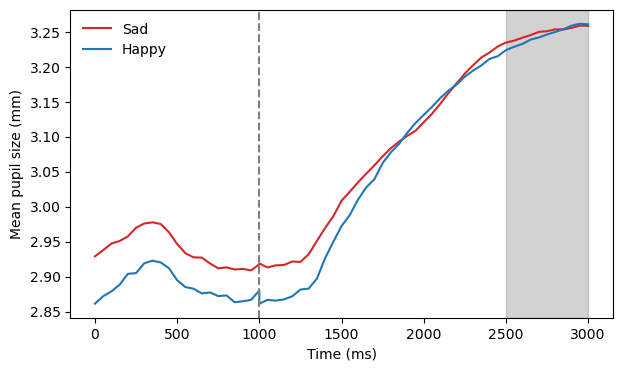

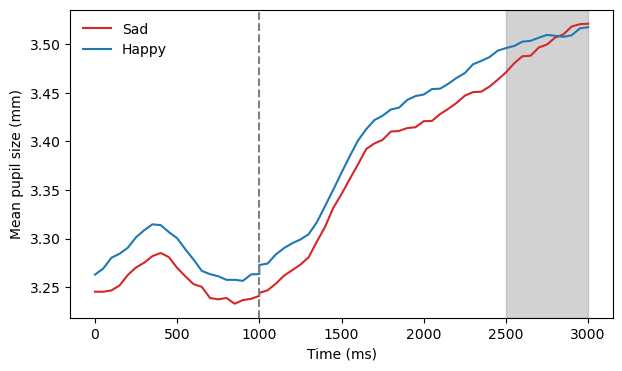

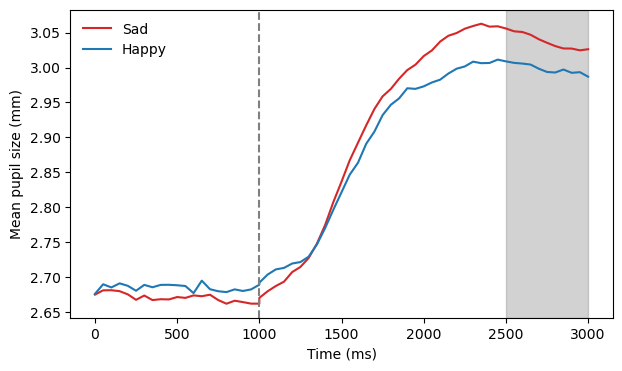

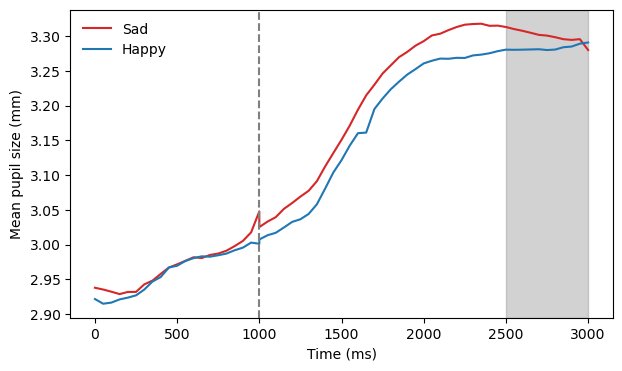

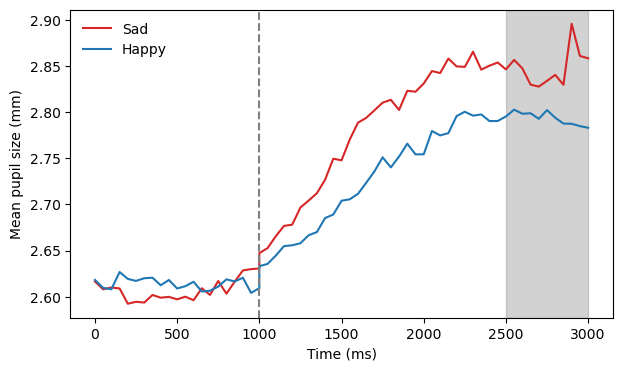

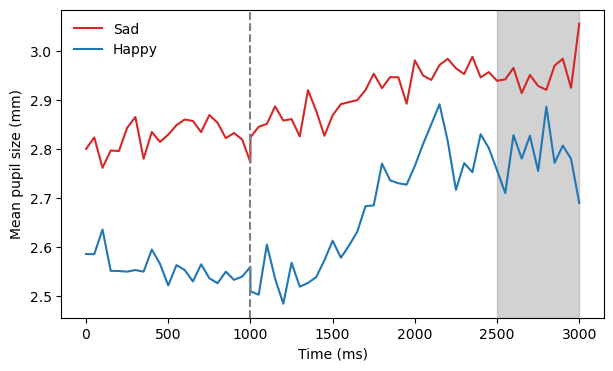

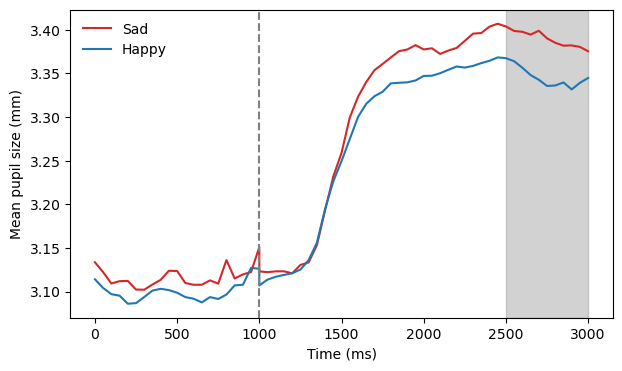

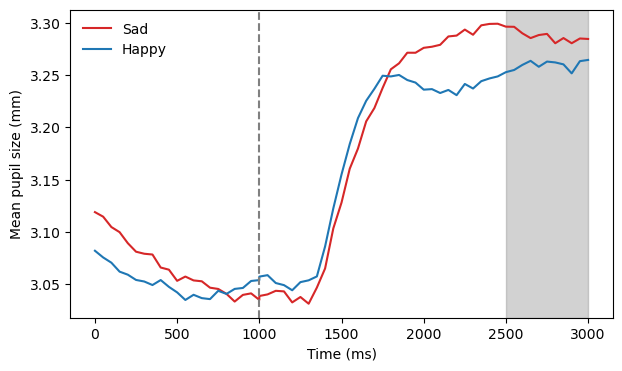

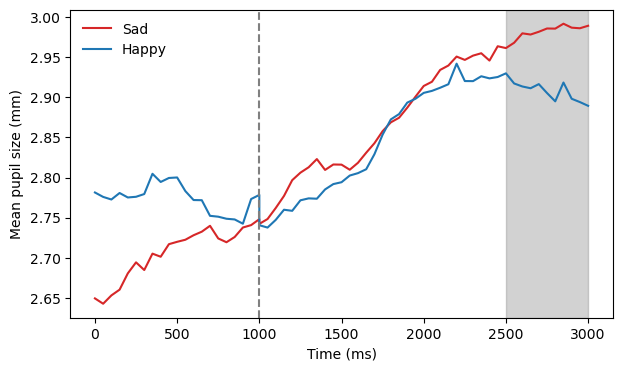

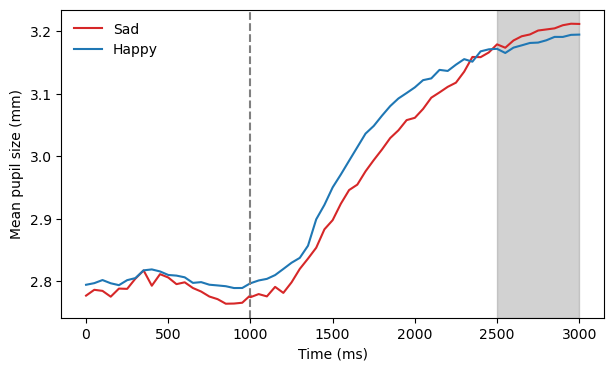

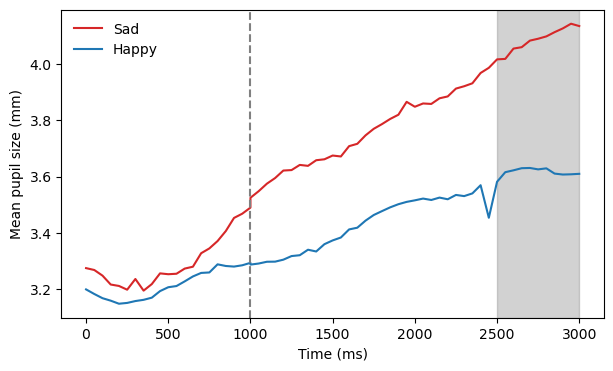

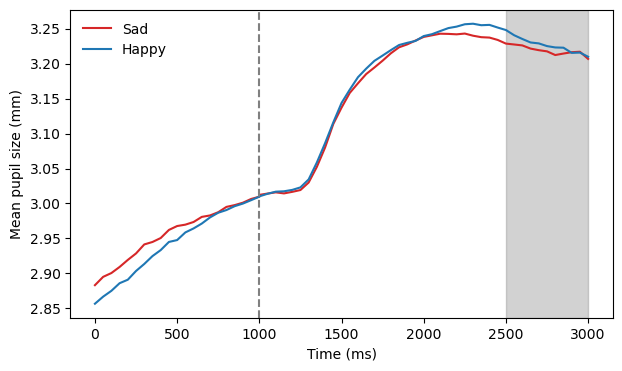

In [35]:
for ppn in sad_stim_df.index.get_level_values("ParticipantName").unique():
    sub_sad_fix_df = sad_fix_df[sad_fix_df.index.get_level_values(
        "ParticipantName") == ppn]
    sub_sad_stim_df = sad_stim_df[sad_stim_df.index.get_level_values(
        "ParticipantName") == ppn]
    sub_happy_fix_df = happy_fix_df[happy_fix_df.index.get_level_values(
        "ParticipantName") == ppn]
    sub_happy_stim_df = happy_stim_df[happy_stim_df.index.get_level_values(
        "ParticipantName") == ppn]

    sad_stim_means = sub_sad_stim_df.mean(axis=0)
    happy_stim_means = sub_happy_stim_df.mean(axis=0)
    sad_fix_means = sub_sad_fix_df.mean(axis=0)
    happy_fix_means = sub_happy_fix_df.mean(axis=0)

    # Prepare data for plotting
    t = np.concatenate([sad_fix_means.index.values,
                        (sad_stim_means.index + sad_fix_means.index[-1]).values])
    sad_means = pd.concat([sad_fix_means, sad_stim_means])
    sad_means.index = t

    happy_means = pd.concat([happy_fix_means, happy_stim_means])
    happy_means.index = t

    plt.figure(figsize=(7, 4))
    plt.plot(sad_means, label="Sad", color="C3")
    plt.plot(happy_means, label="Happy")
    plt.legend(frameon=False)
    plt.ylabel("Mean pupil size (mm)")
    plt.xlabel("Time (ms)")
    plt.axvline(x=1000, color='gray', linestyle='--')
    plt.axvspan(2500, 3000, color='gray', alpha=0.35)
    plt.savefig(INTERIM_REPORTS_DIR / "ss_ts_condition" /
                f"{ppn}_pupil_dilation.png")

# Visualization #2
Baseline corrected version

In [8]:
def pivot_bc_stimulus_data(df: pd.DataFrame, segment_type: str = "stimulus") -> pd.DataFrame:
    """
    Pivot the stimulus data to have the trial_nr as the index and the RelativeTime_ms as the columns
    """
    stimulus_data = df[df.segment_type == segment_type]
    return stimulus_data.pivot(
        index=["ParticipantName", "trial_nr", "segment_type", "%samples_stimulus",
               "%samples_fixation", "Emotion"],
        columns="RelativeTime_ms",
        values="pupilsize_baseline_corrected",
    )

In [10]:
# Stimulus data
filepath_generator = INTERIM_DATA_DIR.glob("*cleaned.parquet")
dataset_loader = map(pd.read_parquet, filepath_generator)
pivotter = map(lambda x: pivot_bc_stimulus_data(x, "stimulus"), dataset_loader)
df_cleaner = map(pivotted_df_cleaner, pivotter)
bc_stimulus_df = pd.concat(df_cleaner)
bc_stimulus_df

RelativeTime_ms ParticipantName  trial_nr segment_type Emotion         0  \
41                          A66        42     stimulus   happy  0.254226   
56                          A66        57     stimulus   happy  0.059371   
59                          A66        60     stimulus   happy  0.034304   
61                          A66        62     stimulus   happy  0.128868   
67                          A66        68     stimulus   happy -0.223734   
..                          ...       ...          ...     ...       ...   
203                         A47       216     stimulus     sad  0.084434   
207                         A47       220     stimulus     sad  0.085250   
209                         A47       222     stimulus   happy  0.050583   
211                         A47       224     stimulus     sad  0.064428   
213                         A47       226     stimulus   happy  0.085376   

RelativeTime_ms        16        17        33        34  49  ...  1768  1818  \
41                    NaN  0.200623       NaN       NaN NaN  ...   NaN   NaN   
56                    NaN  0.059371       NaN  0.183217 NaN  ...   NaN   NaN   
59                    NaN  0.024304       NaN  0.024304 NaN  ...   NaN   NaN   
61               0.068868       NaN  0.113868       NaN NaN  ...   NaN   NaN   
67                    NaN -0.108734 -0.118734       NaN NaN  ...   NaN   NaN   
..                    ...       ...       ...       ...  ..  ...   ...   ...   
203              0.074434       NaN  0.059434       NaN NaN  ...   NaN   NaN   
207                   NaN  0.070250  0.080250       NaN NaN  ...   NaN   NaN   
209                   NaN  0.035583  0.035583       NaN NaN  ...   NaN   NaN   
211                   NaN  0.053800  0.093800       NaN NaN  ...   NaN   NaN   
213                   NaN  0.105376  0.100376       NaN NaN  ...   NaN   NaN   

RelativeTime_ms  1868  1901  1951  118  168  218  268  318  
41                NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
56                NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
59                NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
61                NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
67                NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
..                ...   ...   ...  ...  ...  ...  ...  ...  
203               NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
207               NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
209               NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
211               NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
213               NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  

[7516 rows x 943 columns]

In [12]:
# Aggregate the data into 16ms bins
bc_stimulus_df = bc_stimulus_df.set_index(
    ["ParticipantName",	"trial_nr", "Emotion", "segment_type"])

# Round each column name to the nearest 16ms and create a mapping
bc_rounded_columns_stimulus_df = {col: utils.round_to_nearest_16ms(
    int(col)) for col in bc_stimulus_df.columns}

# Use the mapping to rename the columns, aggregating by taking the mean where columns collapse
plt_bc_stimulus_df = (
    bc_stimulus_df.rename(columns=bc_rounded_columns_stimulus_df).groupby(
        level=0, axis=1).mean()
)

In [13]:
plt_bc_stimulus_df

RelativeTime_ms                                    0         50        100   \
ParticipantName trial_nr Emotion segment_type                                 
A66             42       happy   stimulus      0.227425       NaN  0.290758   
                57       happy   stimulus      0.059371  0.077704 -0.008578   
                60       happy   stimulus      0.029304  0.032637  0.021804   
                62       happy   stimulus      0.098868  0.103868  0.046008   
                68       happy   stimulus     -0.166234 -0.169204 -0.229087   
...                                                 ...       ...       ...   
A47             216      sad     stimulus      0.079434  0.076100  0.109434   
                220      sad     stimulus      0.077750  0.070250  0.060250   
                222      happy   stimulus      0.043083  0.045583  0.043917   
                224      sad     stimulus      0.059114  0.094219  0.092761   
                226      happy   stimulus      0.095376  0.105376  0.120376   

RelativeTime_ms                                    150       200       250   \
ParticipantName trial_nr Emotion segment_type                                 
A66             42       happy   stimulus      0.180157  0.259091  0.292425   
                57       happy   stimulus     -0.012296  0.056935  0.019883   
                60       happy   stimulus      0.044304  0.014304  0.009304   
                62       happy   stimulus     -0.020411  0.030535  0.136961   
                68       happy   stimulus     -0.142067 -0.172067 -0.152067   
...                                                 ...       ...       ...   
A47             216      sad     stimulus      0.101100  0.109434  0.107767   
                220      sad     stimulus      0.051917  0.035250  0.011917   
                222      happy   stimulus      0.017250  0.023917  0.022250   
                224      sad     stimulus      0.089428  0.079428  0.072761   
                226      happy   stimulus      0.127043  0.128664  0.131952   

RelativeTime_ms                                    300       350       400   \
ParticipantName trial_nr Emotion segment_type                                 
A66             42       happy   stimulus      0.102425  0.249091  0.319692   
                57       happy   stimulus     -0.000629  0.021871  0.012704   
                60       happy   stimulus     -0.004029  0.005971  0.027637   
                62       happy   stimulus      0.046961  0.061728  0.069108   
                68       happy   stimulus     -0.130400 -0.138734 -0.148734   
...                                                 ...       ...       ...   
A47             216      sad     stimulus      0.126100  0.141100  0.164434   
                220      sad     stimulus      0.014704  0.015796  0.046917   
                222      happy   stimulus      0.035583  0.055583  0.092250   
                224      sad     stimulus      0.097761  0.106095  0.152761   
                226      happy   stimulus      0.170376  0.203618  0.246997   

RelativeTime_ms                                    450   ...      1550  \
ParticipantName trial_nr Emotion segment_type            ...             
A66             42       happy   stimulus      0.379692  ...  0.554024   
                57       happy   stimulus      0.016935  ...  0.196037   
                60       happy   stimulus      0.007637  ...  0.074304   
                62       happy   stimulus      0.130054  ...  0.083868   
                68       happy   stimulus     -0.108734  ...  0.352933   
...                                                 ...  ...       ...   
A47             216      sad     stimulus      0.199434  ...  0.126100   
                220      sad     stimulus      0.079676  ...  0.023583   
                222      happy   stimulus      0.123917  ...  0.407250   
                224      sad     stimulus      0.191095  ...  0.186513   
                226      hap

In [15]:
# select the data
sad_stim_df = plt_bc_stimulus_df[plt_bc_stimulus_df.index.get_level_values(
    "Emotion") == "sad"]
happy_stim_df = plt_bc_stimulus_df[plt_bc_stimulus_df.index.get_level_values(
    "Emotion") == "happy"]

# calculate average pupil dilation per time bin of 16ms
sad_stim_means = sad_stim_df.mean(axis=0)
happy_stim_means = happy_stim_df.mean(axis=0)

/Users/lukasspiess/Library/CloudStorage/OneDrive-SpiessSolution/Pupil Dilation Processing/General/Data_analysis/pupil_dilation/reports/figures/adults/bc_pd_ts_condition.png


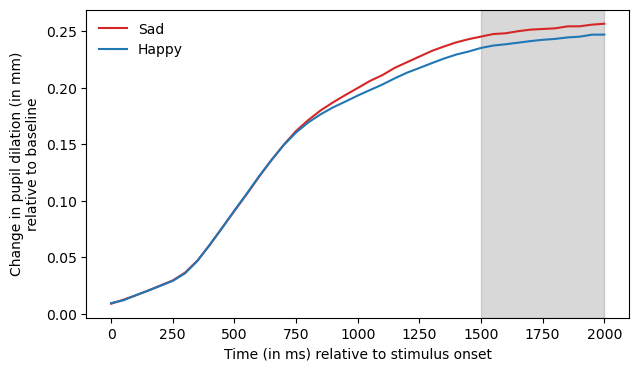

In [25]:
# The Visualization
plt.figure(figsize=(7, 4))
plt.plot(sad_stim_means, label="Sad", color="C3")
plt.plot(happy_stim_means, label="Happy")
plt.legend(frameon=False)
plt.ylabel("Change in pupil dilation (in mm)\nrelative to baseline")
plt.xlabel("Time (in ms) relative to stimulus onset")
plt.axvspan(1500, 2000, color='gray', alpha=0.3)
# plt.show()

plt.savefig(REPORTS_DIR / "bc_pd_ts_condition.png", dpi=300)
print(str(REPORTS_DIR / "bc_pd_ts_condition.png"))